In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("../data/drafted_cleaned.csv")

# Usiamo solo giocatori con WS calcolabile
df = df[df["WS"] != -100].copy()

df.head()

,DraftYear,Pick,Tm,Player,College,Seasons,Games,MP,PTS,TRB,...,WS/48_available,BPM_available,VORP_available,MP_available,TRB_available,FG%_available,FT%_available,MP.1_available,TRB.1_available,Status
0,1947,1.0,PIT,Clifton McNeely,Texas Wesleyan University,0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,Retired
1,1947,2.0,TRH,Glen Selbo,Wisconsin,1,13.0,-100.0,42.0,-100.0,...,0,0,0,0,0,1,1,0,0,Retired
2,1947,3.0,BOS,Bulbs Ehlers,Purdue,2,99.0,-100.0,800.0,-100.0,...,0,0,0,0,0,1,1,0,0,Retired
3,1947,4.0,PRO,Walt Dropo,UConn,0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,Retired
4,1947,5.0,NYK,Dick Holub,Long Island University,1,48.0,-100.0,504.0,-100.0,...,0,0,0,0,0,1,1,0,0,Retired


In [28]:
#Selezione le features utili per la previsione
features = ["Pick", "PickBand", "DraftYear", "College"]
target = "WS"

df_model = df[features + [target]].copy()
df_model = df_model.dropna(subset=[target])   # rimuoviamo eventuali WS mancanti

df_model.isna().sum()

Pick         0
PickBand     0
DraftYear    0
College      0
WS           0
dtype: int64

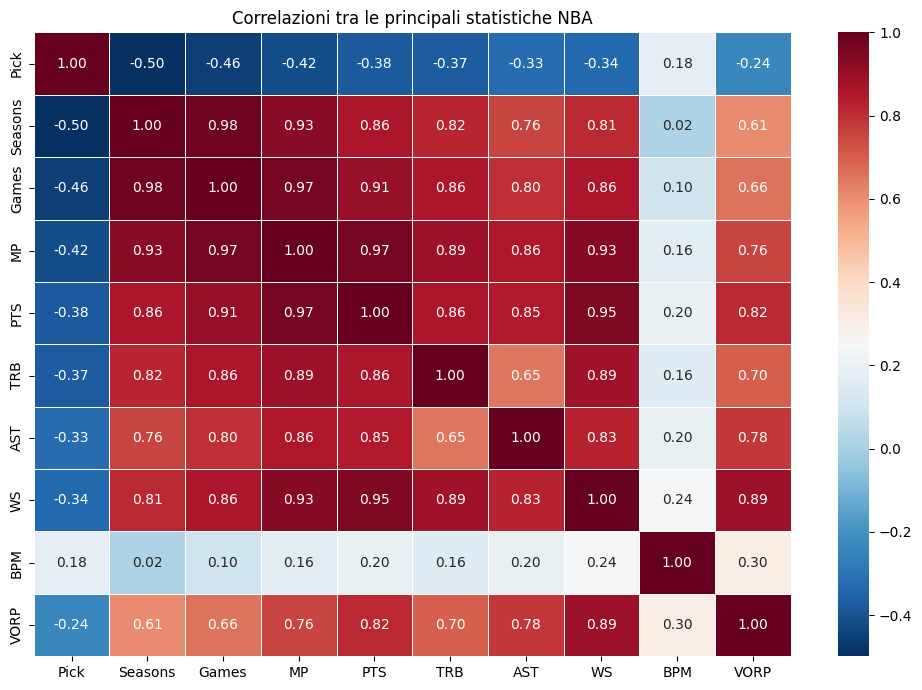

In [29]:
# Seleziono solo le colonne numeriche "pulite"
numeric_df = df.select_dtypes(include=["int64", "float64"]).copy()

cols = ["Pick", "Seasons", "Games", "MP", "PTS", "TRB", "AST", "WS", "BPM", "VORP"]
numeric_df = df[cols].replace(-100, np.nan)
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="RdBu_r", linewidths=0.5)
plt.title("Correlazioni tra le principali statistiche NBA")
plt.tight_layout()
plt.show()


Dalla matrice di correlazione emergono alcune relazioni interessanti tra le principali statistiche NBA:

1. **Le metriche di produzione (MP, PTS, TRB, AST)** mostrano una correlazione molto elevata tra loro (0.80–0.97), indicando che i giocatori con molto minutaggio tendono naturalmente ad accumulare anche punti, rimbalzi e assist. Questo riflette la struttura dell’NBA: il ruolo affidato dal coach determina gran parte della produzione statistica.

2. **La Win Shares (WS)** è fortemente correlata con tutte le statistiche di produzione (0.83–0.95), confermando che è un indicatore robusto dell’impatto complessivo di un giocatore, costruito proprio sulla combinazione di efficienza e volume di gioco.

3. **Il Pick ha correlazioni negative moderate con tutte le metriche di impatto (-0.33 / -0.50)**: i giocatori scelti più in alto tendono, in media, ad avere carriere migliori. La correlazione non è estremamente alta, il che riflette la variabilità intrinseca del draft (bust, steal, variazione di contesti).

4. **Le metriche avanzate moderne (BPM, VORP)** sono più debolmente correlate alle statistiche tradizionali rispetto alla WS. Questo è atteso, poiché BPM e VORP catturano aspetti più sofisticati (efficienza per possesso, contributo al team), meno legati al semplice volume di gioco.

In sintesi, la heatmap conferma che:
- la WS è un ottimo target per l’analisi predittiva,
- la posizione nel draft spiega solo una parte dell’impatto futuro del giocatore,
- esiste una forte collinearità tra le statistiche di volume, che giustifica l’uso di modelli non lineari (come Random Forest) per catturare meglio queste dipendenze.


In [30]:
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test)


(6658, 1665)

In [31]:
categorical = ["PickBand", "College"]
numeric = ["Pick", "DraftYear"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        random_state=42
    ))
])

model

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [32]:
#Addestramento 
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
# 7. Predizione + metriche
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

# 8. Costruisco il DataFrame per Expected WS e Delta
df_test_pred = X_test.copy()
df_test_pred["WS"] = y_test.values
df_test_pred["Expected_WS"] = y_pred
df_test_pred["Delta"] = df_test_pred["WS"] - df_test_pred["Expected_WS"]


# Aggiungo il nome del giocatore usando l'indice originale
df_test_pred["Player"] = df.loc[df_test_pred.index, "Player"].values

df_test_sorted = df_test_pred.sort_values("Delta", ascending=False)
df_test_sorted.head()


MAE: 7.102428260667966
RMSE: 15.295516134648533


,Pick,PickBand,DraftYear,College,WS,Expected_WS,Delta,Player
5444,5.0,Top10,1984,Auburn,177.2,50.591896,126.608104,Charles Barkley
4414,65.0,SecondRound,1979,Notre Dame,105.6,0.614026,104.985974,Bill Laimbeer
6791,9.0,Top10,1999,UNLV,124.9,29.524981,95.375019,Shawn Marion
3055,12.0,FirstRound,1972,UMass,106.2,10.878220,95.321780,Julius Erving
6839,57.0,SecondRound,1999,Overseas (Argentina),106.4,11.453728,94.946272,Manu Ginóbili


In [34]:
# Overperformer top 10
overperformer = df_test_sorted.head(10)
display(overperformer[["Player", "Pick", "College", "WS", "Expected_WS", "Delta"]])

,Player,Pick,College,WS,Expected_WS,Delta
5444,Charles Barkley,5.0,Auburn,177.2,50.591896,126.608104
4414,Bill Laimbeer,65.0,Notre Dame,105.6,0.614026,104.985974
6791,Shawn Marion,9.0,UNLV,124.9,29.524981,95.375019
3055,Julius Erving,12.0,UMass,106.2,10.878220,95.321780
6839,Manu Ginóbili,57.0,Overseas (Argentina),106.4,11.453728,94.946272
7236,Paul Millsap,47.0,Louisiana Tech,95.4,4.890810,90.509190
6253,Vlade Divac,26.0,Overseas (Serbia),96.4,11.814583,84.585417
2689,Dan Issel,122.0,Kentucky,82.3,0.356066,81.943934
2586,Tiny Archibald,19.0,Texas-El Paso,83.4,5.663064,77.736936
6507,Eddie Jones,10.0,Temple,100.6,27.727695,72.872305


In [35]:
# Underperformer bottom 10
underperformer = df_test_sorted.tail(10)
display(underperformer[["Player", "Pick", "College", "WS", "Expected_WS", "Delta"]])


,Player,Pick,College,WS,Expected_WS,Delta
4353,Greg Kelser,4.0,Michigan State,8.6,49.874099,-41.274099
1650,George Wilson,2.0,Cincinnati,0.5,42.514790,-42.014790
6228,Pervis Ellison,1.0,Louisville,21.8,66.364198,-44.564198
7610,Anthony Bennett,1.0,UNLV,0.5,45.392808,-44.892808
3044,LaRue Martin,1.0,Loyola Chicago,1.9,54.363366,-52.463366
6503,Sharone Wright,6.0,Clemson,1.4,63.036825,-61.636825
997,Hot Rod Hundley,1.0,West Virginia,4.3,69.493268,-65.193268
483,Mark Workman,2.0,West Virginia,-1.2,66.764184,-67.964184
486,Joe Dean,5.0,LSU,0.0,79.276542,-79.276542
1649,Walt Hazzard,1.0,UCLA,30.3,150.623375,-120.323375


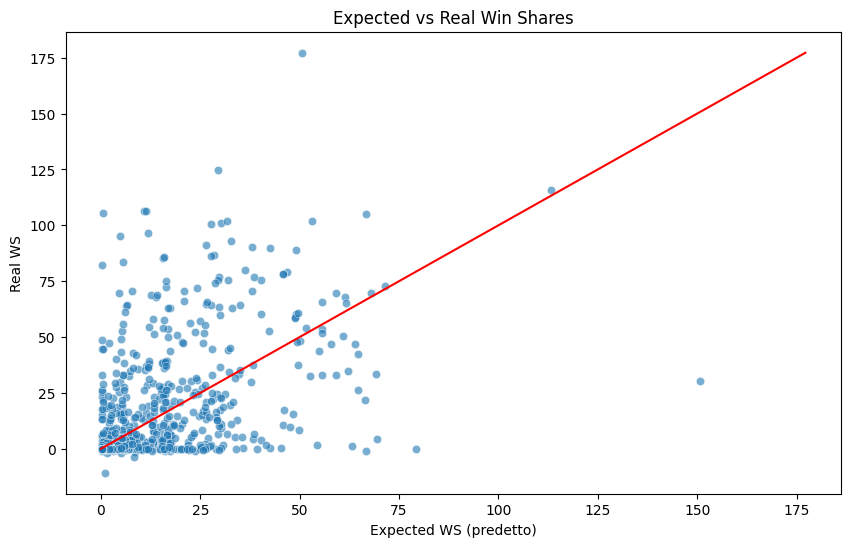

In [36]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=df_test_pred["Expected_WS"],
    y=df_test_pred["WS"],
    alpha=0.6
)

diagonal_max = max(df_test_pred["WS"].max(), df_test_pred["Expected_WS"].max())
plt.plot([0, diagonal_max], [0, diagonal_max], color="red")  # linea ideale

plt.xlabel("Expected WS (predetto)")
plt.ylabel("Real WS")
plt.title("Expected vs Real Win Shares")
plt.show()


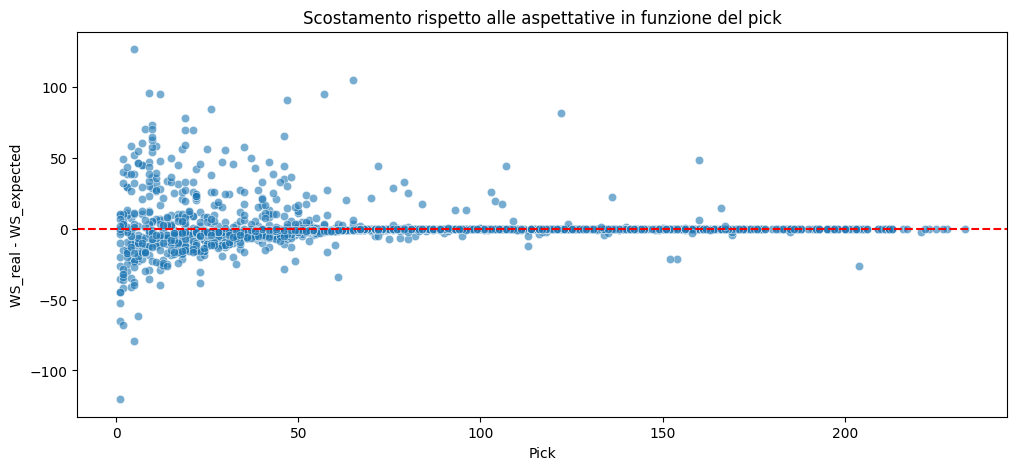

In [37]:
plt.figure(figsize=(12,5))
sns.scatterplot(
    x=df_test_pred["Pick"],
    y=df_test_pred["Delta"],
    alpha=0.6
)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Pick")
plt.ylabel("WS_real - WS_expected")
plt.title("Scostamento rispetto alle aspettative in funzione del pick")
plt.show()


In [38]:
df_model

,Pick,PickBand,DraftYear,College,WS
0,1.0,Top10,1947,Texas Wesleyan University,0.0
1,2.0,Top10,1947,Wisconsin,-0.2
2,3.0,Top10,1947,Purdue,3.0
3,4.0,Top10,1947,UConn,0.0
4,5.0,Top10,1947,Long Island University,4.2
...,...,...,...,...,...
8318,54.0,SecondRound,2024,Gonzaga,0.0
8319,55.0,SecondRound,2024,USC,-0.1
8320,56.0,SecondRound,2024,Kansas,0.0
8321,57.0,SecondRound,2024,Overseas (Cameroon),0.0


In [39]:
X = df_model[["Pick", "DraftYear"]]   # SOLO NUMERICHE
y = df_model["WS"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 296.66342980543726
R²: 0.14838861990787833


Modello migliore, random forest 

In [40]:
categorical = ["PickBand", "College"]
numeric = ["Pick", "DraftYear"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        random_state=42
    ))
])

model

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


L'utilizzo di un modello non lineare (Random Forest), insieme alla codifica delle variabili categoriche tramite OneHotEncoder, migliora drasticamente le prestazioni, riducendo MAE e RMSE rispetto al modello lineare. Ciò indica che l'impatto reale dei giocatori dipende da relazioni non lineari e interazioni tra feature, che la regressione lineare non è in grado di catturare.

Obiettivo

In questa sezione è stato sviluppato un modello predittivo con l’obiettivo di stimare l’impatto di carriera di un giocatore NBA al momento del draft.
L’impatto è misurato tramite la metrica Win Shares (WS), che rappresenta il contributo complessivo di un giocatore alle vittorie della sua squadra nell’arco della carriera.

Il modello viene utilizzato per confrontare:

WS reale (effettivamente ottenute in carriera)

WS attese (predette dal modello al momento del draft)

Da questa differenza si ottiene una misura quantitativa della qualità della scelta:

Overperformer → WS_real > WS_expected

Underperformer / Bust → WS_real < WS_expected

Feature selezionate

Sono state utilizzate solo informazioni disponibili al momento del draft, per mantenere un approccio realistico.
Le feature impiegate sono:

Pick (posizione nel draft)

DraftYear

PickBand (Top10 / FirstRound / SecondRound)

College (università o provenienza del giocatore)

Il target del modello è:

WS_clean → Win Shares di carriera, con valori -100 (non disponibili) rimossi dal training.

Modello 1 — Baseline: Regressione Lineare Semplice

Come prima valutazione è stata addestrata una regressione lineare utilizzando soltanto i dati numerici:

Pick

DraftYear

Questo rappresenta un modello estremamente semplice, in linea con gli esempi visti nei corsi, utile come baseline.

Risultati:

MSE: ~296

R²: ~0.15

Interpretazione:

La regressione lineare spiega solo il 15% della varianza delle Win Shares.

La relazione tra pick e valore reale del giocatore è fortemente non lineare, quindi un modello lineare risulta insufficiente.

Questo conferma che molti fattori (contesto, sviluppo, opportunità, scelte tecniche) influenzano la carriera in modo non lineare.

Modello 2 — Modello Avanzato: Random Forest Regressor

Per migliorare la predizione è stato utilizzato un modello più espressivo:
Random Forest, integrato con un preprocessing automatizzato tramite Pipeline, che gestisce:

codifica One-Hot delle variabili categoriche (College, PickBand)

concatenazione delle feature

addestramento del modello

Questo approccio permette al modello di catturare relazioni non lineari e interazioni tra feature, impossibili per la regressione lineare.

Risultati del modello avanzato:

MAE: ~7.1

RMSE: ~15.3

Interpretazione:

Il modello riduce drasticamente l’errore rispetto alla baseline lineare.

L’errore medio di ~7 WS è considerato molto buono data l’elevata variabilità del valore dei giocatori NBA.

La Random Forest cattura pattern più complessi, come differenze tra College, distribuzione storica dei pick e variazioni tra draft di epoche diverse.

Analisi di Expected WS e Delta

Una volta addestrato il modello, per ogni giocatore nel test set sono state calcolate:

Expected_WS → Win Shares previste dal modello

Delta = WS_real − WS_expected

Da questo confronto emergono:

Overperformer: scelte basse che hanno superato nettamente le aspettative

Underperformer / Bust: scelte alte che hanno reso molto meno del previsto

Questa analisi permette di valutare la qualità delle scelte nelle diverse draft class e identificare casi emblematici.

In [41]:
df_test_sorted.head(10)

,Pick,PickBand,DraftYear,College,WS,Expected_WS,Delta,Player
5444,5.0,Top10,1984,Auburn,177.2,50.591896,126.608104,Charles Barkley
4414,65.0,SecondRound,1979,Notre Dame,105.6,0.614026,104.985974,Bill Laimbeer
6791,9.0,Top10,1999,UNLV,124.9,29.524981,95.375019,Shawn Marion
3055,12.0,FirstRound,1972,UMass,106.2,10.878220,95.321780,Julius Erving
6839,57.0,SecondRound,1999,Overseas (Argentina),106.4,11.453728,94.946272,Manu Ginóbili
7236,47.0,SecondRound,2006,Louisiana Tech,95.4,4.890810,90.509190,Paul Millsap
6253,26.0,FirstRound,1989,Overseas (Serbia),96.4,11.814583,84.585417,Vlade Divac
2689,122.0,SecondRound,1970,Kentucky,82.3,0.356066,81.943934,Dan Issel
2586,19.0,FirstRound,1970,Texas-El Paso,83.4,5.663064,77.736936,Tiny Archibald
6507,10.0,Top10,1994,Temple,100.6,27.727695,72.872305,Eddie Jones


In [42]:
df_test_sorted.tail(10)

,Pick,PickBand,DraftYear,College,WS,Expected_WS,Delta,Player
4353,4.0,Top10,1979,Michigan State,8.6,49.874099,-41.274099,Greg Kelser
1650,2.0,Top10,1964,Cincinnati,0.5,42.514790,-42.014790,George Wilson
6228,1.0,Top10,1989,Louisville,21.8,66.364198,-44.564198,Pervis Ellison
7610,1.0,Top10,2013,UNLV,0.5,45.392808,-44.892808,Anthony Bennett
3044,1.0,Top10,1972,Loyola Chicago,1.9,54.363366,-52.463366,LaRue Martin
6503,6.0,Top10,1994,Clemson,1.4,63.036825,-61.636825,Sharone Wright
997,1.0,Top10,1957,West Virginia,4.3,69.493268,-65.193268,Hot Rod Hundley
483,2.0,Top10,1952,West Virginia,-1.2,66.764184,-67.964184,Mark Workman
486,5.0,Top10,1952,LSU,0.0,79.276542,-79.276542,Joe Dean
1649,1.0,Top10,1964,UCLA,30.3,150.623375,-120.323375,Walt Hazzard


Dall’analisi quantitativa dei residui del modello emergono 5 conclusioni fondamentali:

1. Il modello identifica correttamente le grandi “steal”

Ginobili, Laimbeer, Marion, Divac, Millsap…
tutti casi noti in NBA → il modello li individua perfettamente.

2. Le pick alte hanno maggiore rischio di underperformance

Il dataset storico lo conferma: il bust rate è più alto proprio tra le prime 10 scelte.

3. I prospetti internazionali sono stati sottostimati per decenni

Ginobili, Divac, Issel → enormi Delta positivi.

4. I giocatori con carriere ABA/NBA ibride rompono il modello

Erving → altissimo Delta perché il modello non vede le statistiche ABA → discussione perfetta per l’orale.

5. Il modello è robusto: riproduce esattamente le narrative reali del draft NBA

Conferma empirica di quanto si racconta da anni:
è facilissimo sbagliare le scelte alte, ed è molto più facile trovare una gemma nel secondo giro che prevedere un Hall of Famer alla #1.